## Imports

In [140]:
import sys
import numpy as np
import pandas as pd
from fingerprints.get_fp import output, input

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 


import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from plotnine import *

In [141]:
odorants = pd.read_csv('data/odorants.csv')
labels = pd.read_csv('data/labels.csv')
labels_ = labels.set_index("CID").iloc[:, 1:]
solubility = pd.read_csv('data/solubility.csv')

fingerprint = input

## Data exploration and preparation

In [142]:
odorants.columns, labels.columns, solubility.columns

(Index(['CID', 'MolecularWeight', 'IsomericSMILES', 'IUPACName', 'name',
        'num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
        'num_of_O_atoms', 'num_of_N_atoms', 'PolarA', 'PolarB', 'TopoCharge',
        'VdW', 'AromaticA', 'AromaticB', 'HBondAcceptorCount',
        'HBondDonorCount', 'XLogP', 'TPSA'],
       dtype='object'),
 Index(['CID', 'IsomericSMILES', 'alcoholic', 'aldehydic', 'alliaceous',
        'almond', 'animal', 'anisic', 'apple', 'apricot',
        ...
        'tobacco', 'tomato', 'tropical', 'vanilla', 'vegetable', 'violet',
        'warm', 'waxy', 'winey', 'woody'],
       dtype='object', length=115),
 Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
        'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
        'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
        'measured log solubility in mols per litre', 'smiles'],
       dtype='object'))

In [143]:
# check if there are missing values
odorants.isna().any()


CID                   False
MolecularWeight       False
IsomericSMILES        False
IUPACName              True
name                  False
num_of_atoms          False
num_of_heavy_atoms    False
num_of_C_atoms        False
num_of_O_atoms        False
num_of_N_atoms        False
PolarA                False
PolarB                False
TopoCharge            False
VdW                   False
AromaticA             False
AromaticB             False
HBondAcceptorCount    False
HBondDonorCount       False
XLogP                 False
TPSA                  False
dtype: bool

Only the IUPACName is missing values, but that shouldn't be a big deal

In [144]:
# check the count of each label

label_count = pd.DataFrame(labels.iloc[:, 2:].sum())
label_count.columns = ['Count']
label_count


,Count
alcoholic,83
aldehydic,25
alliaceous,68
almond,50
animal,48
...,...
violet,26
warm,40
waxy,242
winey,174


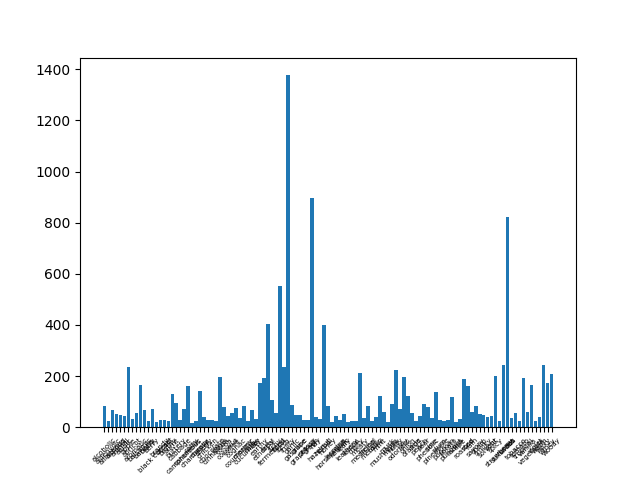

In [145]:
# barplot and rotate the x-axis labels
fig, ax = plt.subplots()
ax.bar(label_count.index, label_count["Count"]) 
plt.xticks(rotation=45, fontsize = 5)

plt.show()

In [146]:
# we see a class imbalance in the labeled data
# we cant see the x-axis labels clearly, so look at the head and tail of the ordered df to determine which labels have the highest and lowest counts
label_count.sort_values('Count', ascending = False)

,Count
fruity,1377
green,896
sweet,821
floral,551
fatty,403
...,...
leathery,20
horseradish,20
musk,20
radish,20


In [147]:
# results head tail label count
#               Count
# fruity        1377
# green         896
# sweet         821
# floral        551
# fatty         403

# leathery      20
# horseradish   20
# musk          20
# radish        20
# catty         17

In [148]:
# Now if we would look at the count of odor descriptions per CID (e.g. per compound)
compound_count = pd.DataFrame(labels_.sum(1))
compound_count.columns = ['Count']
# compound_count

In [149]:
# to big to plot, so we will look at the head and tail of the ordered df to determine which CIDs have the highest and lowest counts
compound_count.sort_values('Count', ascending = False)
# compound_count.sort_values('Count', ascending = False).head(10)
# compound_count.sort_values('Count', ascending = False).tail(10)


,Count
CID,
95594,9
43263,9
605629,9
101363,9
5463910,9
...,...
97883,1
95568,1
94378,1


In [150]:
# we see that the compounds with CID "31260", "121667", and "3776" have a count of zero and thus no odor descriptions
# we could remove these compounds from the dataset since we dont know if the odor of these sturctures is just not available or if it is something else.

c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 47'. Pick better value with 'binwidth'.


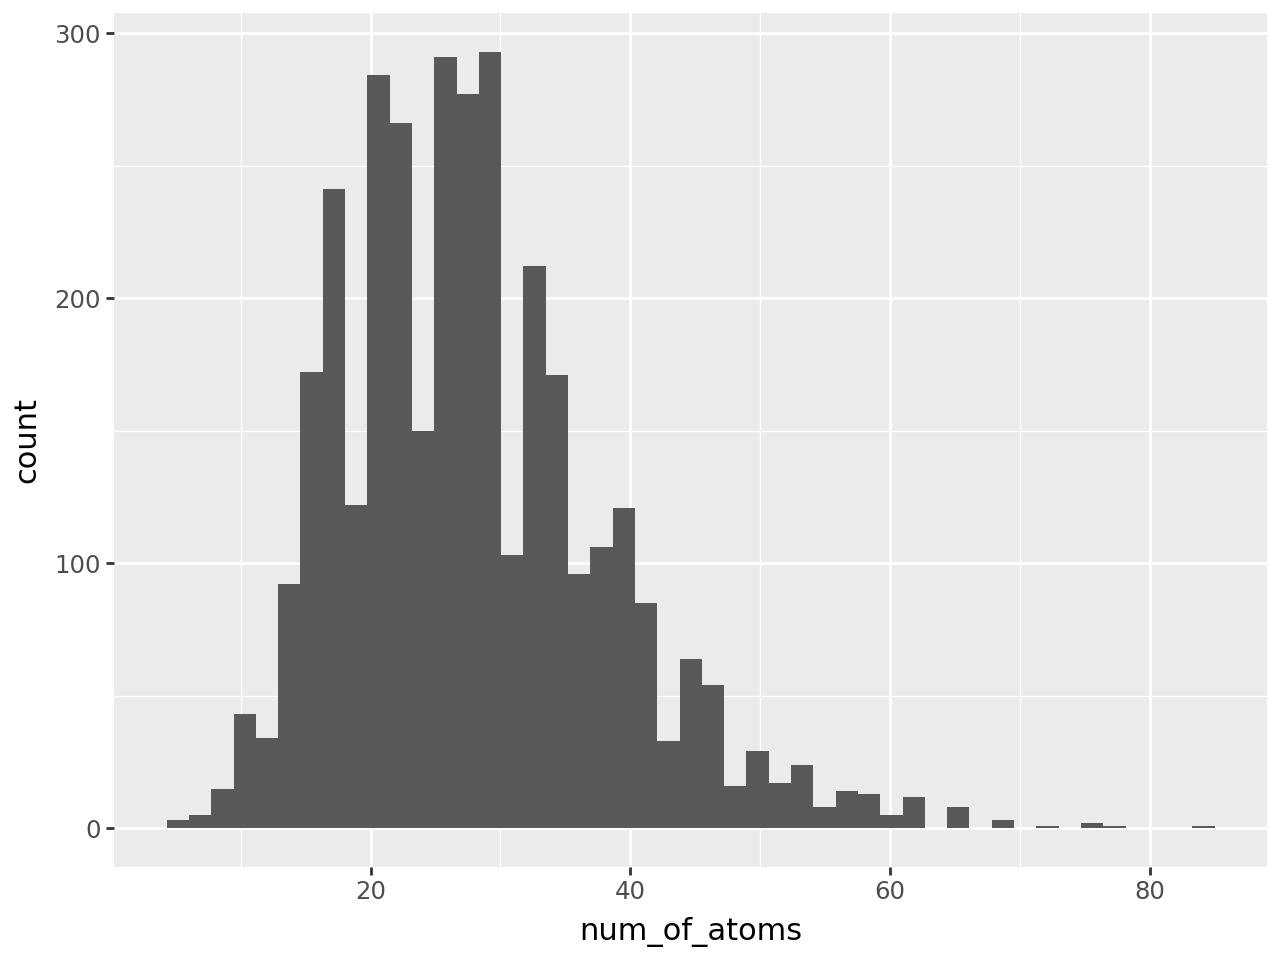

In [151]:
# what else would we want to represent a count from??
# example
ggplot(odorants, aes('num_of_atoms')) + \
    geom_histogram()

In [152]:
# check correlation between every numerical variable in odorants dataset (numerical cause name and smiles dont really contribute maybe? and cant get corr of num-categorical)
num_vars = odorants.select_dtypes(include = ['float64', 'int64'])
num_vars.loc[:, "MolecularWeight":].corr()



,MolecularWeight,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,PolarA,PolarB,TopoCharge,VdW,AromaticA,AromaticB,HBondAcceptorCount,HBondDonorCount,XLogP,TPSA
MolecularWeight,1.000000,0.913047,0.978150,0.923869,0.380665,-0.133188,0.951593,0.866679,-0.102324,0.959450,0.102252,0.101602,0.294155,0.294207,0.294049,0.294272
num_of_atoms,0.913047,1.000000,0.916925,0.935289,0.249481,-0.197838,0.988317,0.972421,-0.129744,0.983916,-0.153663,-0.153624,0.267893,0.270425,0.272957,0.270539
num_of_heavy_atoms,0.978150,0.916925,1.000000,0.966465,0.407493,-0.118332,0.946429,0.840868,-0.083249,0.956250,0.164689,0.164057,0.263148,0.263810,0.264555,0.263905
num_of_C_atoms,0.923869,0.935289,0.966465,1.000000,0.221457,-0.159466,0.959810,0.843742,-0.111864,0.952539,0.137907,0.137802,0.247649,0.252329,0.256950,0.252439
num_of_O_atoms,0.380665,0.249481,0.407493,0.221457,1.000000,-0.291541,0.213364,0.245602,0.144802,0.300273,-0.002377,-0.006213,0.057040,0.044769,0.033126,0.044657
num_of_N_atoms,-0.133188,-0.197838,-0.118332,-0.159466,-0.291541,1.000000,-0.172457,-0.203234,-0.018996,-0.203173,0.319394,0.323660,-0.062957,-0.067689,-0.070541,-0.067308
PolarA,0.951593,0.988317,0.946429,0.959810,0.213364,-0.172457,1.000000,0.948296,-0.138202,0.991670,-0.052387,-0.052316,0.283537,0.286761,0.289805,0.286865
PolarB,0.866679,0.972421,0.840868,0.843742,0.245602,-0.203234,0.948296,1.000000,-0.141570,0.943326,-0.278511,-0.278453,0.282392,0.286357,0.289052,0.286371
TopoCharge,-0.102324,-0.129744,-0.083249,-0.111864,0.144802,-0.018996,-0.138202,-0.141570,1.000000,-0.134384,-0.077875,-0.078161,-0.033601,-0.040153,-0.047782,-0.040151
VdW,0.959450,0.983916,0.956250,0.952539,0.300273,-0.203173,0.991670,0.943326,-0.134384,1.000000,-0.078551,-0.079217,0.303410,0.305838,0.307470,0.305903


## Adding amount of sulphur atoms per molecule to odorants dataframe

In [153]:
#Voor elke smiles if S is in it add to count
#maak dictionary met CID: sulphur count 
sulphur_counts = {}

# Loop over each row in df
for index, row in odorants.iterrows():
    sulphur_count = row['IsomericSMILES'].count('S')
    # maak dict van de counts en corresponding CID
    sulphur_counts[row['CID']] = sulphur_count

#convert deze dict into df and add deze dictionary to the df odorants 
sulphur_counts_df = pd.DataFrame(list(sulphur_counts.items()), columns=['CID', 'Sulphur atoms'])
print(sulphur_counts_df)

odorants["Sulphur atoms"] = sulphur_counts_df["Sulphur atoms"]
print(odorants.head())

            CID  Sulphur atoms
0             4              0
1            58              0
2            98              1
3           101              0
4           107              0
...         ...            ...
3482  154241350              3
3483  155323379              3
3484  158699780              1
3485  161504856              0
3486  162353069              5

[3487 rows x 2 columns]
   CID  MolecularWeight         IsomericSMILES  \
0    4            75.11                CC(CN)O   
1   58           102.09          CCC(=O)C(=O)O   
2   98           120.13        C(C(=O)C(=O)O)S   
3  101           122.12    C1=CC(=CC(=C1)O)C=O   
4  107           150.17  C1=CC=C(C=C1)CCC(=O)O   

                        IUPACName                    name  num_of_atoms  \
0              1-aminopropan-2-ol      1-aminopropan-2-ol            14   
1              2-oxobutanoic acid      2-oxobutanoic acid            13   
2  2-oxo-3-sulfanylpropanoic acid  3-mercaptopyruvic acid            11   
3 

## K-means clustering

### 2 PC PCA, tot explained variance = 21,6%

In [154]:
pca = PCA(2)
X = pca.fit_transform(labels_.T)
explained_var = pca.explained_variance_ratio_
explained_var.sum()

0.21600598166123203

In [155]:
m9 = KMeans(n_clusters = 9, random_state = 12345).fit(X) 
m11 = KMeans(n_clusters = 11, random_state = 12345).fit(X) 
df_pc2 = pd.DataFrame(X)
df_pc2["_clusters_9"] = pd.Categorical(m9.labels_)
df_pc2["_clusters_11"] = pd.Categorical(m11.labels_)


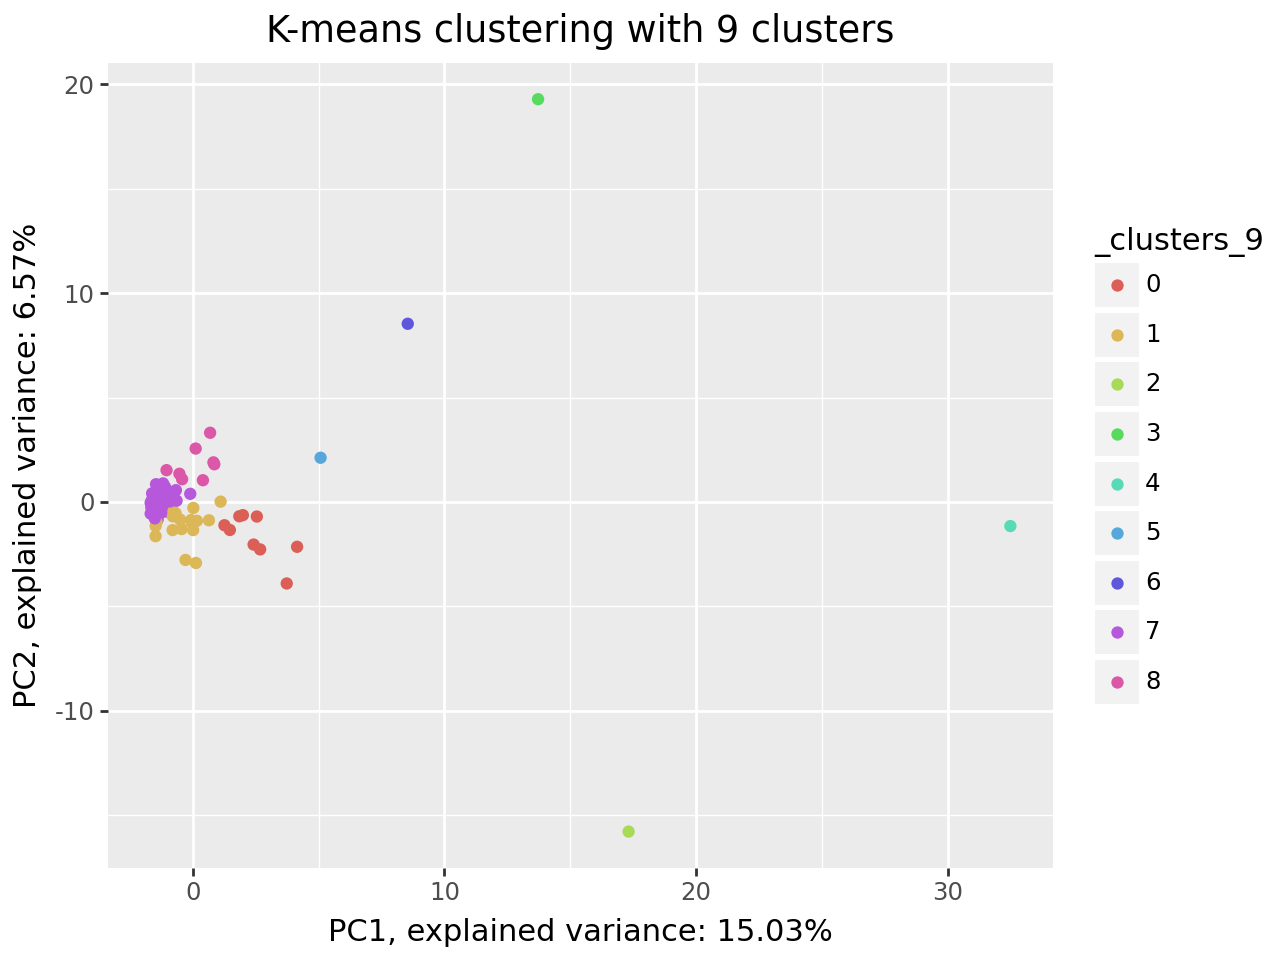

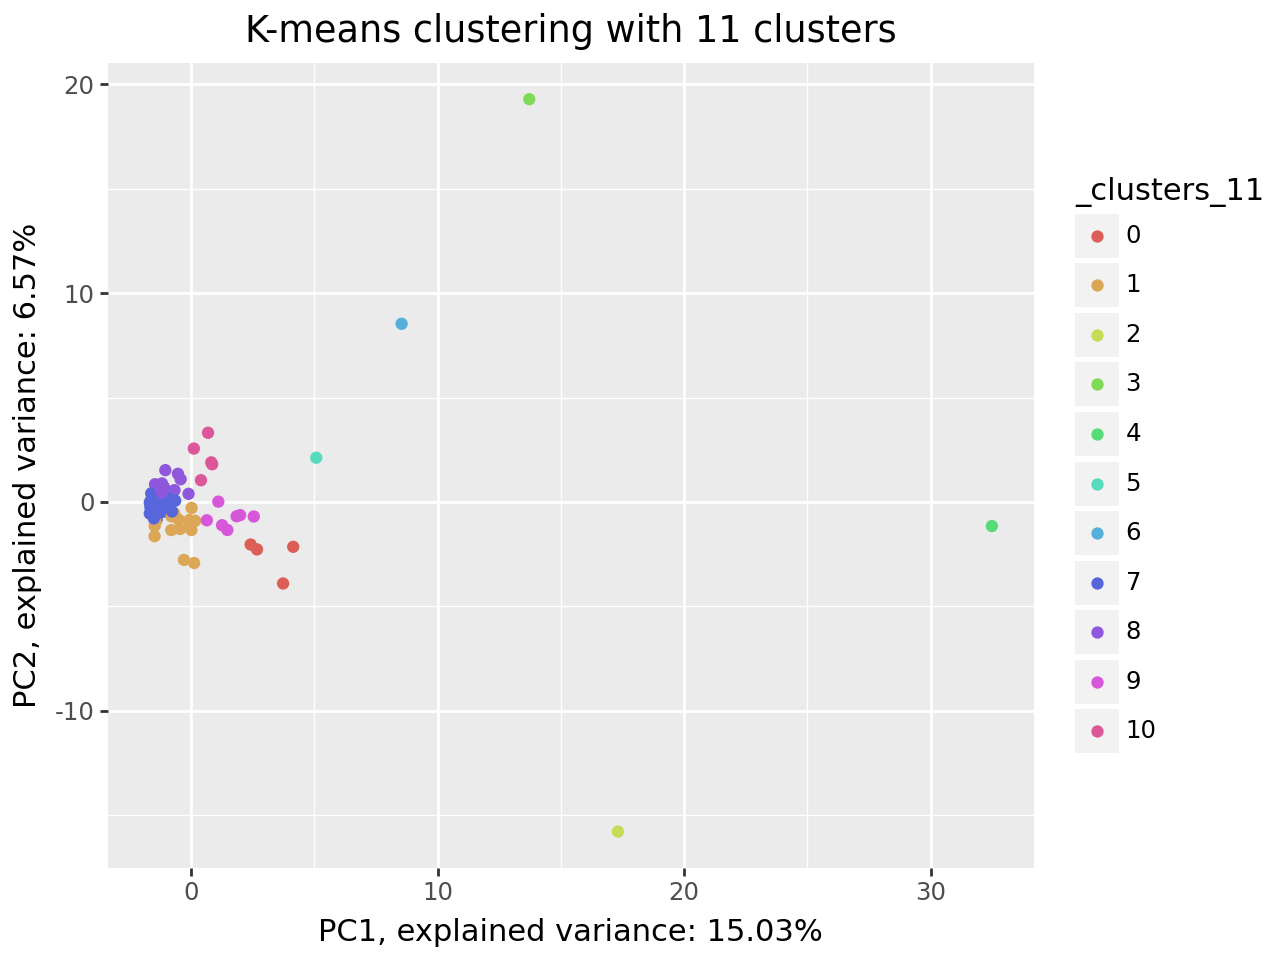

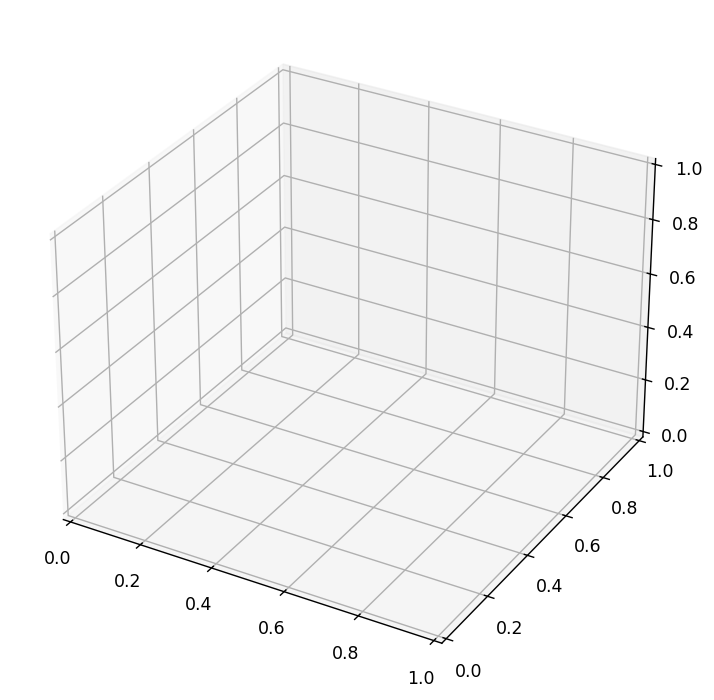

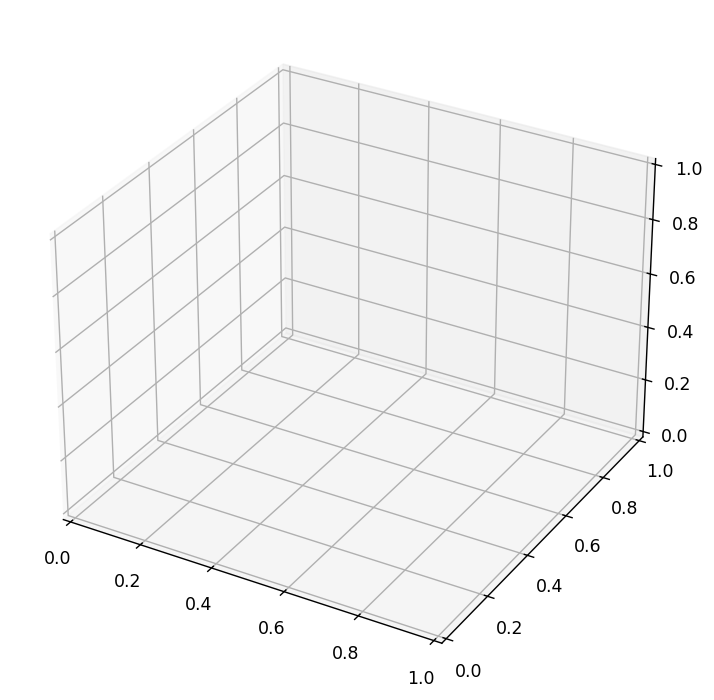

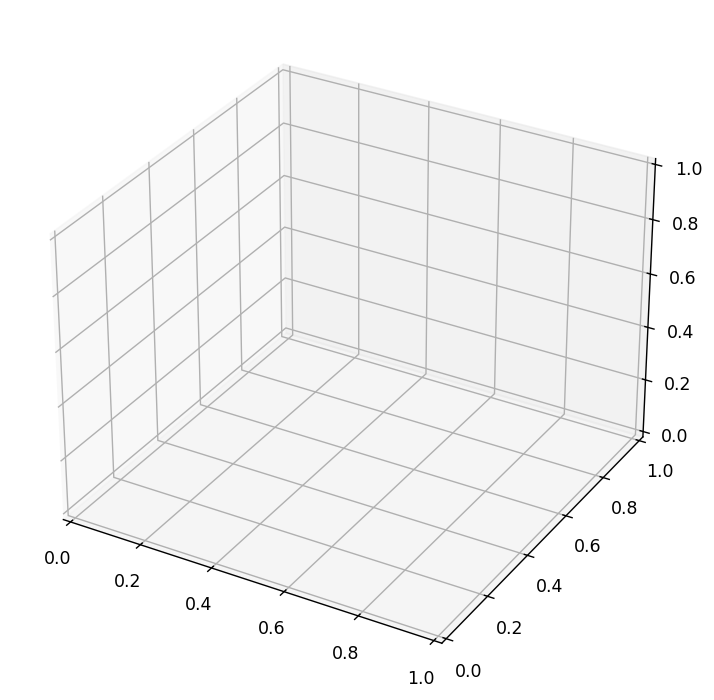

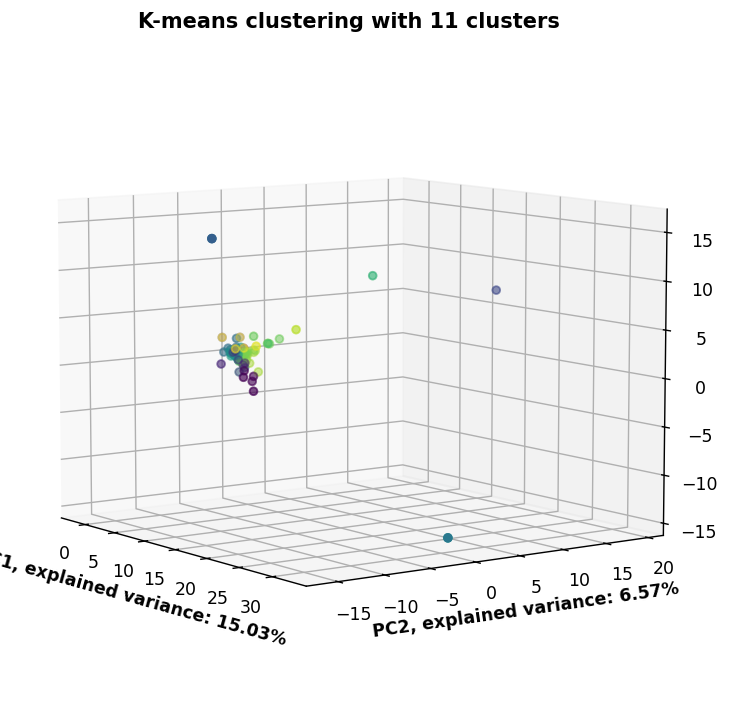

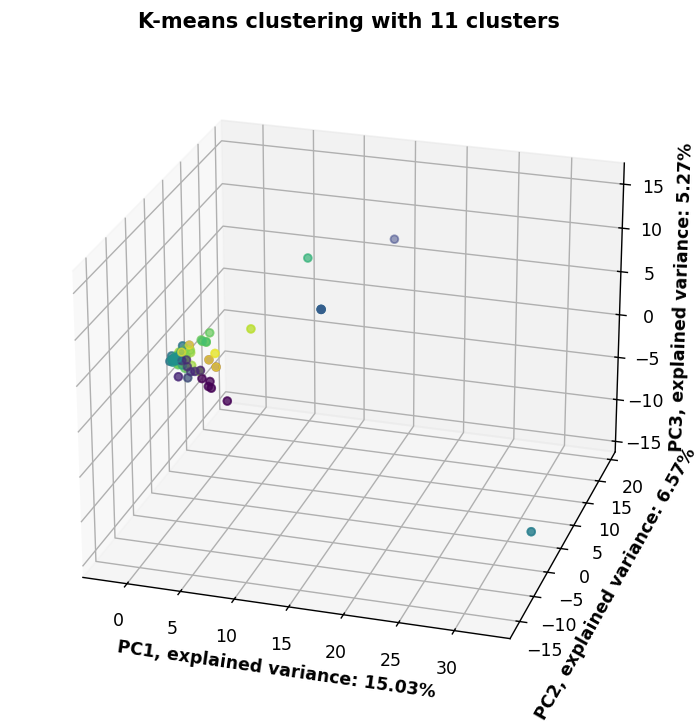

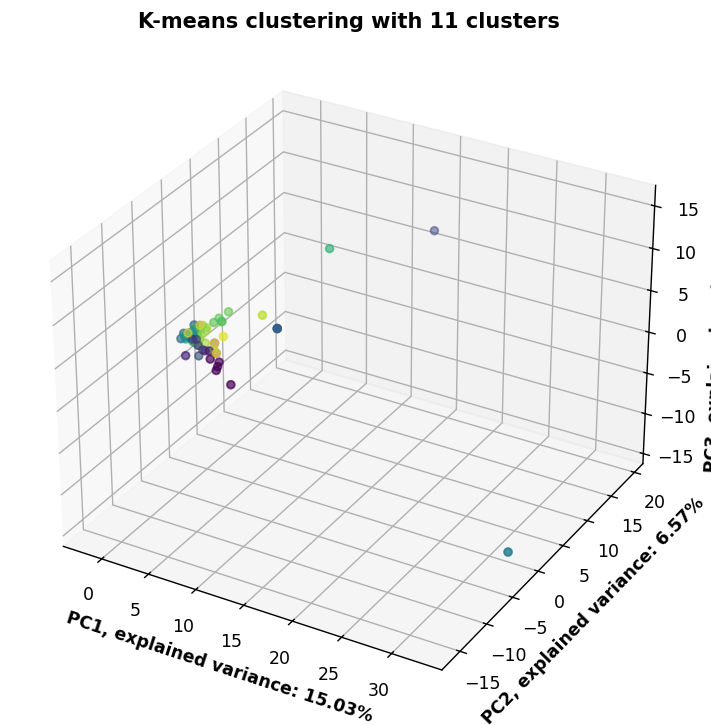

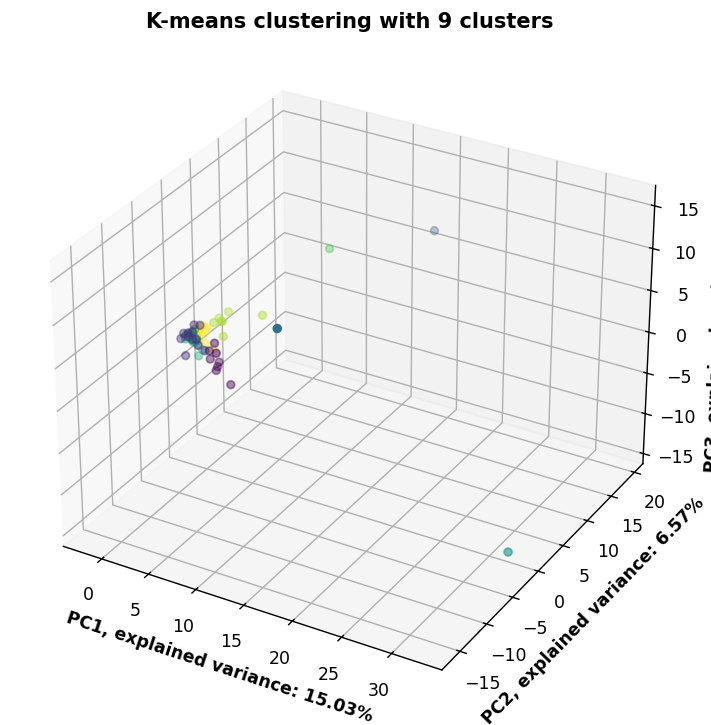

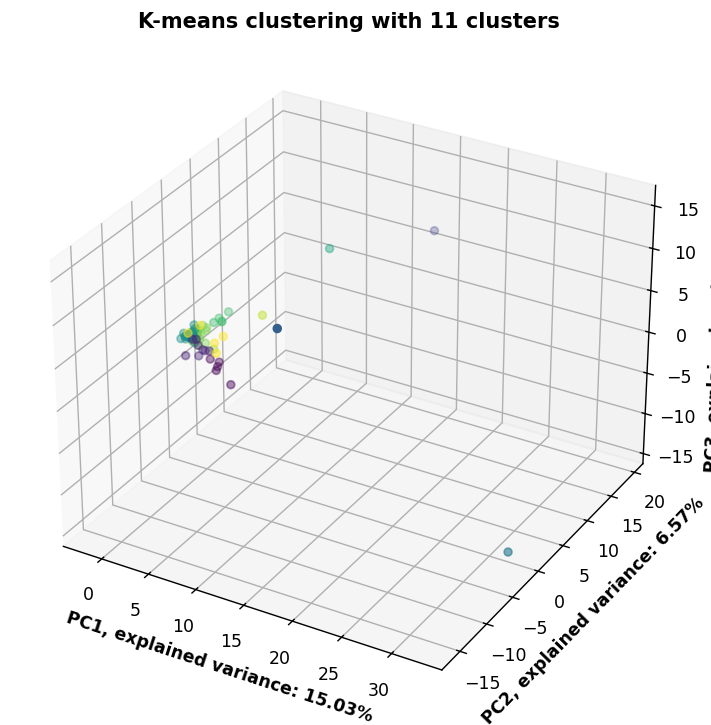

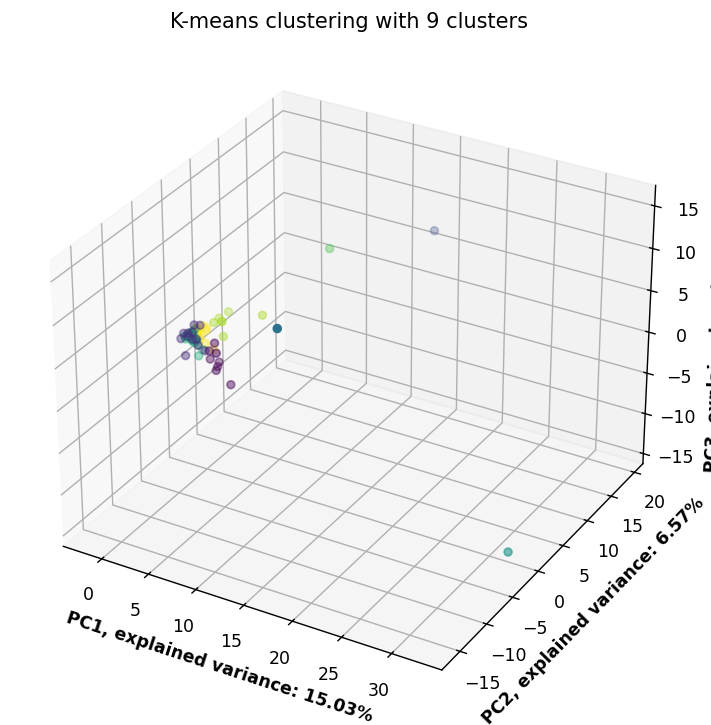

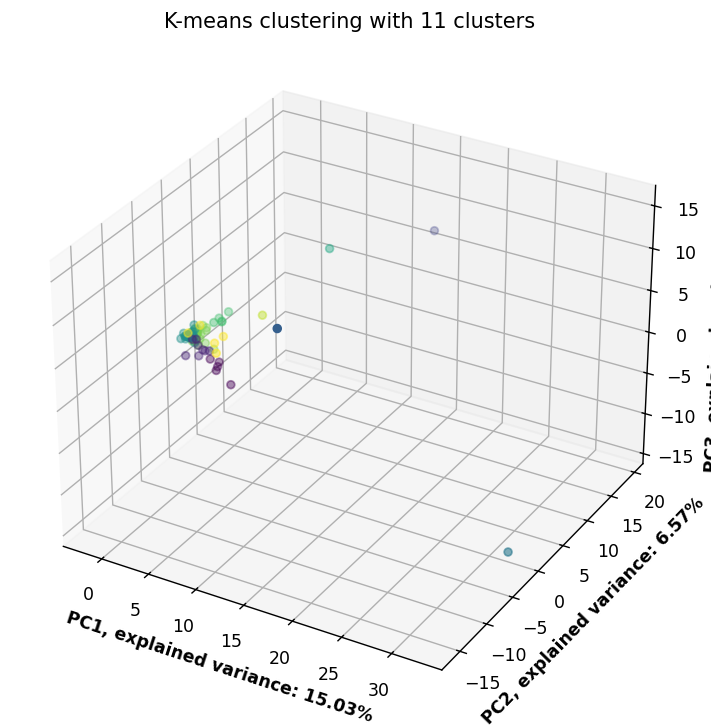

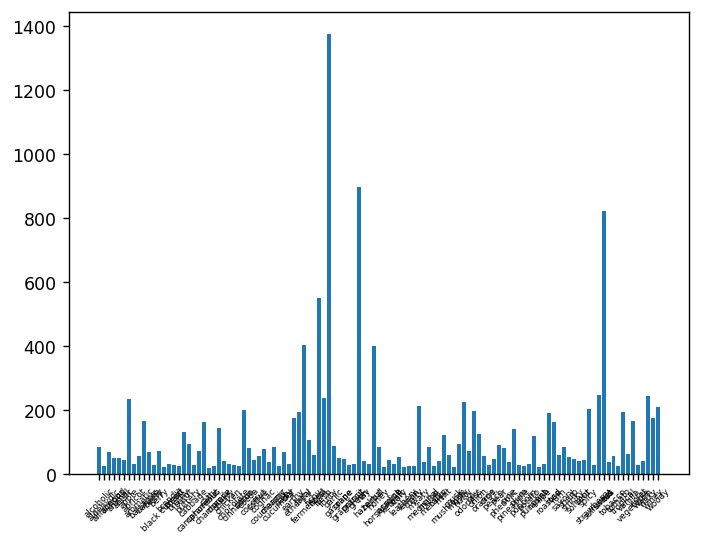

In [156]:
%matplotlib inline

for i in [9, 11]:
    p = ggplot(df_pc2, aes(df_pc2.loc[:, 0], df_pc2.loc[:, 1], color = f"_clusters_{i}")) +\
    geom_point() +\
    xlab(f"PC1, explained variance: {explained_var[0]*100:.2f}%") +\
    ylab(f"PC2, explained variance: {explained_var[1]*100:.2f}%") +\
    labs(title = f"K-means clustering with {i} clusters")
    
    p.show()

### 3 PC PCA, tot explained variance = 26,8%

In [157]:
# Import libraries for 3d plotting and interactivity
import ipympl
from mpl_toolkits import mplot3d

In [158]:
# Doing PCA with 3 PCs
pca = PCA(3)
label_3pc = pca.fit_transform(labels_.T)
exp_var = pca.explained_variance_ratio_
total_exp_var = exp_var.sum()
total_exp_var


0.2687020713799013

In [159]:
m9 = KMeans(n_clusters = 9, random_state = 12345).fit(label_3pc) 
m11 = KMeans(n_clusters = 11, random_state = 12345).fit(label_3pc) 
df_pc3 = pd.DataFrame(label_3pc)
df_pc3["_clusters_9"] = pd.Categorical(m9.labels_)
df_pc3["_clusters_11"] = pd.Categorical(m11.labels_)


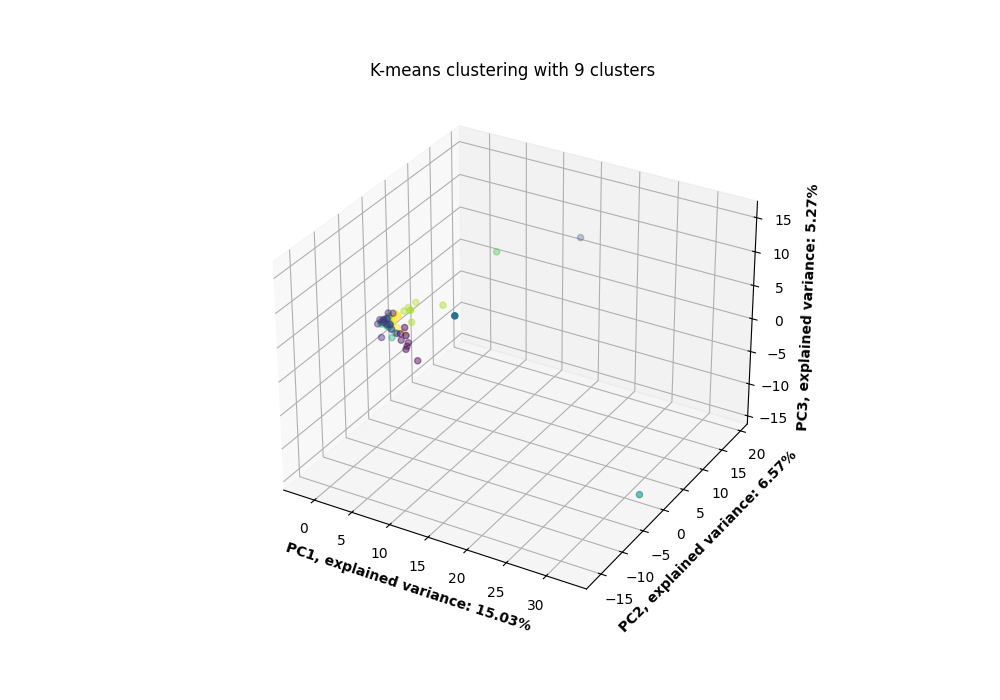

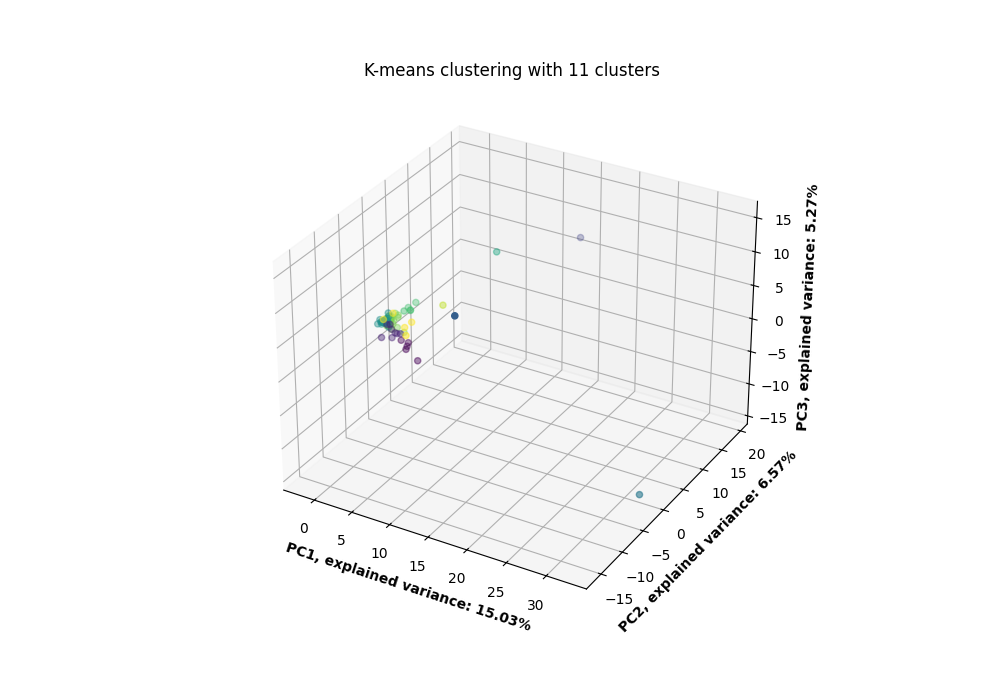

In [160]:
%matplotlib widget

# Creating plot
# colors = {0:"red",1:"blue",2:"green",3:"yellow",4:"orange",5:"pink",6:"purple",7:"cyan",8:"brown"}
for i in [9, 11]:
    # Creating figure
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")

    ax.scatter3D(df_pc3[0], df_pc3[1], df_pc3[2], c = df_pc3[f"_clusters_{i}"])
    # plt.title("Scoreplot of first three PCs of compound odor data")
    plt.title(f"K-means clustering with {i} clusters")
    ax.set_xlabel(f"PC1, explained variance: {exp_var[0]*100:.2f}%", fontweight = "bold")
    ax.set_ylabel(f"PC2, explained variance: {exp_var[1]*100:.2f}%", fontweight = "bold")
    ax.set_zlabel(f"PC3, explained variance: {exp_var[2]*100:.2f}%", fontweight = "bold")

    plt.show()

# show legend of plot
# for i in range(9):
#     ax.scatter([], [], [], c = list(colors.values())[i], label = f"Cluster {i}")
# legend = ax.legend()
 

In [161]:
df_pc3["labels"] = labels_.columns

for n_cluster in [9, 11]:
    print(f"K-means with {n_cluster} clusters")
    print("---"*10)
    d = {}
    d_samples = {}

    for i in range(n_cluster):
        d[i] = set()
        l = df_pc3.loc[df_pc3[f"_clusters_{n_cluster}"] == i, "labels"].values
        d[i].update(l)
    
    for k, v in d.items():
        samples = set(labels_[labels_[list(v)].eq(1).any(axis=1)].index)
        d_samples[k] = samples
        print(f"Cluster {k + 1} has {len(v)} unique labels and {len(samples)} unique samples.")
        print(f"labels: {v}\nsamples: {samples}\n")

K-means with 9 clusters
------------------------------
Cluster 1 has 8 unique labels and 1220 unique samples.
labels: {'pineapple', 'apple', 'fatty', 'winey', 'waxy', 'ethereal', 'tropical', 'oily'}
samples: {8193, 8194, 8195, 229377, 12293, 12294, 24583, 12296, 12297, 61446, 61450, 69644, 8205, 229385, 8207, 61455, 8209, 229387, 522255, 5271566, 77845, 5463914, 6914062, 61466, 86043, 30748, 8221, 8222, 5312542, 12613663, 18467, 54531251, 43046, 12327, 6184, 12329, 104487, 12331, 73771, 10285, 81964, 118823, 24624, 5367848, 92210, 5369076, 16205867, 58165301, 12344, 16441, 58, 12348, 5365824, 8257, 643139, 148244548, 256071, 94282, 5312586, 12366, 12367, 19963983, 524369, 77907, 61524, 143444, 6430804, 5365850, 102491, 243803, 112733, 102495, 10341, 94310, 12391, 520296, 12393, 6504553, 8299, 77932, 12397, 12398, 20590, 550768, 102515, 18757749, 101599349, 18554, 5362579, 6436990, 129, 5362580, 94339, 5365891, 19964035, 520326, 1550470, 19964037, 3084426, 14475, 13965455, 118928, 53428

## Manual Clustering (self-made)

In [162]:
manual_labels = ["fruity", "sweet", "green", "earthy", "savoury", "spices", "artificial", "sharp", "general"]
d_manual = {"fruity": ['apple', 'apricot', 'banana', 'berry', 'black currant', 'cherry', 'citrus', 'fruity', 'grape', 'grapefruit', 'lemon', 'melon', 'pineapple', 'plum', 'peach', 'pear', 'orange', 'strawberry', 'tropical', 'sour'],
            "sweet": ['caramellic', 'honey', 'chocolate', 'popcorn', 'sweet', 'coconut', 'creamy', 'buttery', 'dairy', 'milky'],
            "green": ['green', 'horseradish', 'leafy', 'cabbage', 'cucumber', 'tomato', 'fresh', 'radish'],
            "earthy": ['grassy', 'mushroom', 'earthy', 'hay', 'cocoa', 'coffee', 'nutty', 'almond', 'hazelnut', 'fermented', 'animal', 'leathery', 'pine', 'potato', 'ripe', 'vegetable', 'woody'],
            "savoury": ['balsamic', 'beefy', 'alliaceous', 'brothy', 'cheesy', 'chicken', 'fishy', 'garlic', 'malty', 'meaty', 'fatty', 'onion', 'savory', 'bread', 'roasted'],
			"spices": ['cinnamon', 'anisic', 'camphoreous', 'chamomile', 'coumarinic', 'herbal', 'mint', 'tea', 'tobacco', 'vanilla', 'jasmine', 'floral', 'rose', 'violet'],
			"artificial": ['aldehydic', 'gasoline', 'ketonic', 'medicinal', 'metallic', 'phenolic', 'solvent'],
			"sharp": ['cognac', 'alcoholic', 'brandy', 'rum', 'winey', 'burnt', 'pungent', 'sharp', 'smoky'],
			"general": ['sulfurous', 'aromatic', 'catty', 'dry', 'ethereal', 'musk', 'musty', 'oily', 'orris', 'spicy', 'warm', 'waxy', 'odorless']}

for k, v in d_manual.items():
    samples = set(labels_[labels_[v].eq(1).any(axis=1)].index)
    print(f"{k} has {len(v)} unique labels and {len(samples)} unique samples.")
    print(f"labels: {v}\nsamples: {samples}\n")


fruity has 20 unique labels and 1736 unique samples.
labels: ['apple', 'apricot', 'banana', 'berry', 'black currant', 'cherry', 'citrus', 'fruity', 'grape', 'grapefruit', 'lemon', 'melon', 'pineapple', 'plum', 'peach', 'pear', 'orange', 'strawberry', 'tropical', 'sour']
samples: {8193, 229377, 24583, 229385, 229387, 8205, 6914062, 8207, 90136, 5365794, 73772, 81964, 24624, 90160, 5365818, 3022909, 5365824, 8257, 524369, 6430804, 6430805, 5365850, 5464156, 8294, 442482, 442484, 8314, 125, 129, 5365891, 3022986, 101834900, 5365909, 5365910, 101834902, 16537, 5365916, 98461, 98471, 557223, 8361, 8364, 8365, 176, 8369, 12255414, 8375, 65724, 98492, 68968644, 16582, 32967, 68968648, 91300039, 221393, 5365976, 5365982, 5365992, 16617, 106729, 106730, 221417, 3023083, 8432, 244, 5832948, 8438, 54034681, 24834, 221443, 106756, 261, 24838, 264, 6365451, 106766, 221455, 8469, 5366038, 74008, 16668, 16670, 106788, 8500, 5366074, 5366077, 778574, 24915, 151986522, 74096, 12009861, 19022215, 446304

see also "manual_labels.txt" for the exact labels included in each cluster.

## Manual clustering expert

In [163]:
manual_expert = pd.read_csv('data/labels_manual_expert.csv').set_index("CID")
terms_per_cluster = pd.read_csv('data/umbrella_terms_HM.csv', sep=";", header=None).iloc[:, 1:]

def to_lowercase(column):
    return column.str.lower()

terms_per_cluster
terms_per_cluster = terms_per_cluster.apply(to_lowercase)

In [164]:
manual_expert_labels = list(manual_expert.columns)
d_manual_expert = {}

for row in terms_per_cluster.iterrows():
    d_manual_expert[manual_expert_labels[row[0]]] = set(row[1].dropna().values)

to_remove = set()
for k, v in d_manual_expert.items():
    for item in v:
        if item not in labels_.columns:
            to_remove.add(item)
    v = v - to_remove
    samples = set(labels_[labels_[list(v)].eq(1).any(axis=1)].index)
    print(f"{k} has {len(v)} unique labels and {len(samples)} unique samples.")
    print(f"labels: {v}\nsamples: {samples}\n")


print(f"{len(to_remove)} expert odor labels were not present in our dataset and removed")




green has 5 unique labels and 926 unique samples.
labels: {'leafy', 'green', 'grassy', 'cucumber', 'radish'}
samples: {229377, 87287812, 12293, 12294, 12296, 61450, 61451, 69644, 61453, 6914062, 61455, 77840, 14297102, 522262, 61464, 86280216, 86044, 256028, 5363741, 12613663, 16418, 18467, 5365794, 104487, 6184, 5367848, 69674, 10285, 90160, 92210, 12339, 3086387, 104513, 643139, 148244548, 94282, 5312586, 61517, 12367, 19963983, 108625, 77907, 61524, 143444, 5365847, 12377, 112733, 12386, 8299, 6428782, 101599349, 6436990, 5365891, 19964035, 1550470, 3084426, 150030476, 118928, 80018, 101834900, 5365909, 5365910, 101834902, 101834904, 14489, 110747, 98461, 39071, 346273, 10402, 10405, 557222, 557223, 6430892, 80046, 98478, 346286, 12255414, 54155447, 11344071, 68968648, 37065, 61641, 91300039, 16592, 86278356, 10453, 106711, 6435033, 522459, 10460, 641248, 12514, 641256, 106729, 28906, 106730, 221417, 3023083, 8432, 12528, 12529, 6437112, 54034681, 6437114, 69884, 43263, 5368064, 617

## Hierachical

In [165]:
# from sklearn.cluster import AgglomerativeClustering
# from scipy.cluster.hierarchy import dendrogram
# %matplotlib inline

# # from course Data analysis at TU delft
# def plot_dendrogram(X, labels=None, figsize=(14,6), **kwargs):
#     model = AgglomerativeClustering(compute_full_tree = True, compute_distances = True).fit(X)
#     # create the counts of samples under each node
#     counts = np.zeros(model.children_.shape[0])
#     n_samples = len(model.labels_)
#     for i, merge in enumerate(model.children_):
#         current_count = 0
#         for child_idx in merge:
#             if child_idx < n_samples:
#                 current_count += 1  # leaf node
#             else:
#                 current_count += counts[child_idx - n_samples]
#         counts[i] = current_count

#     linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

#     # Plot the corresponding dendrogram
#     plt.figure(figsize=(14,6))
#     dendrogram(linkage_matrix, color_threshold = 0, leaf_rotation = 90, labels=labels, **kwargs)


In [166]:
# plot_dendrogram(labels_.T, labels = labels_.columns)

In [167]:
# plot_dendrogram(labels_, labels = labels_.index)

In [168]:
# X = labels_.T
# X_scaled = StandardScaler().fit_transform(X)
# m9 = AgglomerativeClustering(n_clusters = 9).fit(X)

# df_dist_clust = pd.DataFrame()
# df_dist_clust["_clusters"] = pd.Categorical(m9.labels_)
# df_dist_clust["labels"] = labels_.columns
# df_dist_clust


In [169]:
# d_hrc = {}

# for i in range(9):
#     d_hrc[i] = set()
#     l = df_dist_clust.loc[df_dist_clust["_clusters"] == i, "labels"].values
#     d_hrc[i].update(l)
    
# for k, v in d_hrc.items():
#     print(f"Cluster {k} has {len(v)} unique labels")
#     print(k, v)

In [170]:
# new_labels_hrc = new_labels.copy()

# print(new_labels_hrc)

# for i in range(9):
#     new_labels_hrc[f"cluster_{i}"] = 0

# for i in range(new_labels_hrc.index.size):
# # for i in range(3):
#     l = pd.DataFrame(labels_.iloc[i, :]).T
#     l = l.loc[: ,(l == 1).any()]
#     l = set(col for col in l.columns)

#     for j in range(9):
#         cluster = d_hrc[j]
#         # if any element in l is in cluster
#         if any([elm in cluster for elm in l]):
#             # print(cluster, l)
#             new_labels_hrc.loc[new_labels_hrc.index[i], f"cluster_{j}"] = 1

# new_labels_hrc

## Making new dataframes with clustered samples

In [171]:
new_labels = labels_.copy()
for col in labels_.columns:
    del new_labels[col]

### K-means

In [172]:
new_labels_kmeans_9 = new_labels.copy()
new_labels_kmeans_11 = new_labels.copy()

for n_cluster, df in zip([9, 11], [new_labels_kmeans_9, new_labels_kmeans_11]):
    for i in range(n_cluster):
        df[f"cluster_{i}"] = 0

    for i in range(df.index.size):
        l = pd.DataFrame(labels_.iloc[i, :]).T
        l = l.loc[: ,(l == 1).any()]
        l = set(col for col in l.columns)

        for j in range(9):
            cluster = d[j]
            # if any element in l is in cluster
            if any([elm in cluster for elm in l]):
                # print(cluster, l)
                df.loc[new_labels.index[i], f"cluster_{j}"] = 1


### Manual

In [173]:
new_labels_manual = new_labels.copy()
manual_labels = ["fruity", "sweet", "green", "earthy", "savoury", "spices", "artificial", "sharp", "general"]
d_manual = {"fruity": ['apple', 'apricot', 'banana', 'berry', 'black currant', 'cherry', 'citrus', 'fruity', 'grape', 'grapefruit', 'lemon', 'melon', 'pineapple', 'plum', 'peach', 'pear', 'orange', 'strawberry', 'tropical', 'sour'],
            "sweet": ['caramellic', 'honey', 'chocolate', 'popcorn', 'sweet', 'coconut', 'creamy', 'buttery', 'dairy', 'milky'],
            "green": ['green', 'horseradish', 'leafy', 'cabbage', 'cucumber', 'tomato', 'fresh', 'radish'],
            "earthy": ['grassy', 'mushroom', 'earthy', 'hay', 'cocoa', 'coffee', 'nutty', 'almond', 'hazelnut', 'fermented', 'animal', 'leathery', 'pine', 'potato', 'ripe', 'vegetable', 'woody'],
            "savoury": ['balsamic', 'beefy', 'alliaceous', 'brothy', 'cheesy', 'chicken', 'fishy', 'garlic', 'malty', 'meaty', 'fatty', 'onion', 'savory', 'bread', 'roasted'],
			"spices": ['cinnamon', 'anisic', 'camphoreous', 'chamomile', 'coumarinic', 'herbal', 'mint', 'tea', 'tobacco', 'vanilla', 'jasmine', 'floral', 'rose', 'violet'],
			"artificial": ['aldehydic', 'gasoline', 'ketonic', 'medicinal', 'metallic', 'phenolic', 'solvent'],
			"sharp": ['cognac', 'alcoholic', 'brandy', 'rum', 'winey', 'burnt', 'pungent', 'sharp', 'smoky'],
			"general": ['sulfurous', 'aromatic', 'catty', 'dry', 'ethereal', 'musk', 'musty', 'oily', 'orris', 'spicy', 'warm', 'waxy', 'odorless']}

for l in manual_labels:
    new_labels_manual[l] = 0

for i in range(new_labels_manual.index.size):
    l = pd.DataFrame(labels_.iloc[i, :]).T
    l = l.loc[: ,(l == 1).any()]
    l = set(col for col in l.columns)

    for label in manual_labels:
        cluster = d_manual[label]
        # if any element in l is in cluster
        if any([elm in cluster for elm in l]):
            new_labels_manual.loc[new_labels.index[i], label] = 1

new_labels_manual

,fruity,sweet,green,earthy,savoury,spices,artificial,sharp,general
CID,,,,,,,,,
4,0,0,0,0,1,0,0,0,0
58,0,1,0,0,1,0,0,0,0
98,0,0,0,0,1,0,0,0,1
101,0,1,0,0,0,0,1,0,1
107,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
154241350,0,0,1,0,1,0,0,0,0
155323379,0,0,0,0,1,0,0,0,1
158699780,1,1,0,1,1,0,0,0,1


### Manual (Expert Labels)

In [174]:
new_labels_manual_expert = new_labels.copy()

for l in manual_expert_labels:
    new_labels_manual_expert[l] = 0

for i in range(new_labels_manual_expert.index.size):
    l = pd.DataFrame(labels_.iloc[i, :]).T
    l = l.loc[: ,(l == 1).any()]
    l = set(col for col in l.columns)

    for label in manual_expert_labels:
        cluster = d_manual_expert[label]
        if any([elm in cluster for elm in l]):
            new_labels_manual_expert.loc[new_labels.index[i], label] = 1

new_labels_manual_expert

,green,fruity,flower,savory,animal,herbal,spices,earthy,woody,alcohol,aquatic
CID,,,,,,,,,,,
4,0,0,0,0,0,0,0,0,0,0,0
58,0,0,0,1,0,0,0,0,0,0,0
98,0,0,0,1,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,0,0,0
107,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
154241350,1,0,0,1,0,0,0,0,0,0,0
155323379,0,0,0,1,0,0,0,0,0,0,0
158699780,0,1,0,1,0,0,0,0,0,0,0


In [175]:
compound_count = pd.DataFrame(new_labels_manual_expert.sum(1))
compound_count.columns = ['Count']
missing_in_expert = compound_count.where(compound_count["Count"] == 0).dropna() # 241 compounds with missing descriptions
new_labels_manual_expert.drop(missing_in_expert.index, inplace = True) # remove compounds with no odor descriptions
new_labels_manual_expert

,green,fruity,flower,savory,animal,herbal,spices,earthy,woody,alcohol,aquatic
CID,,,,,,,,,,,
58,0,0,0,1,0,0,0,0,0,0,0
98,0,0,0,1,0,0,0,0,0,0,0
125,0,1,0,1,0,0,0,0,0,0,0
126,0,0,0,1,0,1,0,0,1,0,0
129,0,1,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
154241350,1,0,0,1,0,0,0,0,0,0,0
155323379,0,0,0,1,0,0,0,0,0,0,0
158699780,0,1,0,1,0,0,0,0,0,0,0


### Writing new dataframes to csv files

In [176]:
new_labels_kmeans_9.to_csv("data/labels_kmeans_9.csv")
new_labels_kmeans_11.to_csv("data/labels_kmeans_11.csv")
new_labels_manual.to_csv("data/labels_manual.csv")
new_labels_manual_expert.to_csv("data/labels_manual_expert.csv")
missing_in_expert.to_csv("data/missing_in_expert.csv") # can be used to test model with completely new data and check mannually

# new_labels_hrc.to_csv("data/labels_hrc.csv")